# Sleep Quality Analysis with Machine Learning

## 1. Introduction

The project studies how sleep duration and quality change day-by-day, and how behavior during the previous day affects sleep. The sleep-related factors such as caffeine consumption, activity or stress could have a big impact on sleep. The objective of this project is to find patterns in sleep quality by examining relationshops between sleep and other factors.

- Add literature!
- Motivation for the research question!

## 2. Problem formulation

The first goal of this project is to find patters in sleep quality. The second goal is to examine, what kind of behavior results in higher sleep quality and on the contrary, what kind of behavior hinders sleep. The third goal is to predict sleep quality with machine learning models. These project topics formed the following three study questions:

1. What kind of sleep patterns the subject has?
2. Which features have the highest dependency with sleep quality for the subject?
3. How accurately the features can predict sleep quality when used with machine learning models?

## 3. Dataset description

The dataset contains sleep-related information that was collected by Dana Diotte between the years 2014 – 2018. Data is Diotte’s personal data from the Sleep Cycle application form Northcube. The dataset was published on the website Kaggle.com.
There are in total 887 observations from different days. There are no observations from each day, but from those days that there are, the dataset is mostly well-filled and there is not too much missing data. Ten variables were tracked: Start, End, Sleep quality, Time in bed, Wake up, Sleep Notes, Heart rate, and Activity. The dataset is in .csv format. The dataset is available at: https://www.kaggle.com/datasets/danagerous/sleep-data?select=sleepdata.csv. A second sleep dataset was published later by Diotte to Kaggle. The tracked variables were partly different, and for that reason, in this study only sleepdata.csv is used and sleepdata_2.csv is ignored.

The dataset was cleaned by removing rows with missing data. In the cleaning process it turned out that variables "Hearth rate" and "Wake up" were not appearing with the variable "Activity (steps)". Apparently tracking "Heart rate" and "Wake up" was stopped at some point and "Activity (steps)" was tracked only from August 2016 onwards. As "Activity (steps)" was an interesting variable for analysis, and the other two variables had far less data points, "Heart rate" and "Wake up" were discarded in the cleaning. The number of remaining rows after the cleaning was 254.

Five new variables were extracted from “Sleep Notes”: “Coffee”, “Tea”, “Working out”, “Late eating” and “Stress”. These are binary features that define if these events occurred during the observation day. “Sleep Notes” consisted only of these five markings and thus it was pruned out from the dataset as redundant.

Two more new features "Weekend" and “Late to bed” were extracted using feature "Start". "Weekend" is a binary feature that defines if an observation is recorded on weekend or not. This feature was created because, there is more time to sleep on weekends typically, which could also have an effect on sleep quality, and on the other hand there could be more social events on weekends which could also affect sleep. In this feature Friday-Saturday, observations from Saturday-Sunday and Sunday-Monday nights are considered as weekend. “Late to bed” is also a binary feature that defines if the subject went to sleep between 00:00 and 05:59. This feature was created, because irregular time to go to sleep could affect sleep quality. After creating these two variables, “Start” and “End” were discarded.

In the end, the dataset contained the variables listed in Table 1.


| Name          | Data type   | Description |
| ------------- | ----------- | ----------- |
| Sleep quality | integer [0,100] | Quality of sleep|
| Time in bed   | integer     |Minutes in bed|
| Activity (steps)   | integer     |Number of steps|
| Coffee   | binary     |Drinking coffee at some point of a day|
| Tea   | binary     |Drinking tea at some point of a day|
| Working out  | binary     |Working out at some point of a day|
| Late eating  | binary    |Eating late|
| Stress | binary     |Stress during the day|
| Weekend  | binary    |Observation on Friday - Sunday|
| Late to bed | binary    |Going to bed between 00:00 - 05:59|

                                                        Table 1

## 3.1 Exploratory analysis

In [1]:
# Importing libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np

Fontconfig error: Cannot load default config file: No such file: (null)


### sleepdata.csv (Dataset 1)

In [2]:
# Dataset
sleepdata = pd.read_csv("sleepdata.csv", sep = ";")

row, col = sleepdata.shape

print("The first dataset contains", row, "rows and", col, "columns.")

The first dataset contains 887 rows and 8 columns.


In [4]:
sleepdata.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [5]:
sleepdata.dtypes

Start                object
End                  object
Sleep quality        object
Time in bed          object
Wake up              object
Sleep Notes          object
Heart rate          float64
Activity (steps)      int64
dtype: object

In [6]:
sleepdata.isnull().sum(axis = 0)

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

### sleepdata_2.csv (Dataset 2)

In [3]:
# Dataset
sleepdata2 = data = pd.read_csv("sleepdata_2.csv", sep = ";")

row, col = sleepdata2.shape

print("The second dataset contains", row, "rows and", col, "columns")

The second dataset contains 921 rows and 21 columns


In [8]:
sleepdata2.isnull().sum(axis = 0)

Start                            0
End                              0
Sleep Quality                    0
Regularity                       0
Mood                           921
Heart rate (bpm)                 0
Steps                            0
Alarm mode                       0
Air Pressure (Pa)              429
City                           434
Movements per hour               0
Time in bed (seconds)            0
Time asleep (seconds)            0
Time before sleep (seconds)      0
Window start                    80
Window stop                     80
Did snore                        0
Snore time                       0
Weather temperature (°C)         0
Weather type                     0
Notes                          912
dtype: int64

## 3.2 Data Pre-processing

In [4]:
data_cleaned = sleepdata.copy()

# Dropping columns "End", "Wake up" "Heart rate"
data_cleaned = data_cleaned.drop(["End", "Wake up", "Heart rate"], axis = 1)

# Dropping rows where "Sleep quality", "Sleep Notes" or is NA
data_cleaned = data_cleaned.dropna(subset = ["Sleep quality", "Sleep Notes"])

# Droppin rows where "Activity (steps)" is zero
data_cleaned.drop(data_cleaned[data_cleaned["Activity (steps)"] == 0].index, inplace = True)

# Modifying "Time in bed" into minutes
data_cleaned = data_cleaned.reset_index(drop=True)

for row in range(data_cleaned.shape[0]):
    str_time = data_cleaned["Time in bed"][row]
    if str_time[1] == ":":
        data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
    else:
        data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])

# Modifying "Sleep quality" into an integer and "Time in bed into a numeric"
data_cleaned["Sleep quality"] = data_cleaned["Sleep quality"].apply(lambda row: int(row[:-1]))
data_cleaned["Time in bed"] = pd.to_numeric(data_cleaned["Time in bed"])

# Creating "Late to Bed" feature
data_cleaned["Late to bed"] = pd.to_datetime(data_cleaned["Start"]).dt.hour.map(lambda x: int(x < 6 and x >= 0))

# Creating "Weekend" and "Weekday" features
data_cleaned["Start"] = pd.to_datetime(data_cleaned["Start"]).dt.date
data_cleaned["Weekend"] = pd.to_datetime(data_cleaned["Start"]).dt.dayofweek
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data_cleaned["Weekday"] = data_cleaned.Weekend.map(days)
data_cleaned["Weekend"] = data_cleaned["Weekend"].apply(lambda row: int(row == 4 or row == 5 or row == 6))

# The number of remaining rows
print("The number of remaining rows is", data_cleaned.shape[0])

# Showing the results
data_cleaned.head()

/tmp/ipykernel_173/683748972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
/tmp/ipykernel_173/683748972.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])


The number of remaining rows is 254


,Start,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Late to bed,Weekend,Weekday
0,2016-08-17,78,453,Ate late:Drank coffee:Worked out,7200,0,0,Wednesday
1,2016-08-18,36,504,Drank coffee:Worked out,3444,0,0,Thursday
2,2016-08-20,56,628,Drank coffee,7901,0,1,Saturday
3,2016-08-21,52,491,Drank coffee:Drank tea,3786,0,1,Sunday
4,2016-08-22,35,489,Drank coffee:Worked out,2668,0,0,Monday


In [5]:
# Encoding Sleep Notes into variables
data_cleaned["Sleep Notes"].value_counts()

Drank coffee:Drank tea                             63
Drank coffee:Drank tea:Worked out                  61
Drank tea                                          38
Drank tea:Worked out                               34
Drank coffee:Worked out                            22
Drank coffee                                       19
Drank coffee:Drank tea:Stressful day                4
Drank coffee:Drank tea:Stressful day:Worked out     3
Ate late:Drank coffee:Worked out                    2
Drank tea:Stressful day:Worked out                  2
Drank coffee:Stressful day:Worked out               2
Ate late:Drank coffee:Drank tea:Worked out          2
Drank coffee:Stressful day                          1
Ate late:Drank coffee:Drank tea                     1
Name: Sleep Notes, dtype: int64

In [6]:
# Coffee
data_cleaned["Coffee"] = data_cleaned["Sleep Notes"].apply(lambda row: int("coffee" in row))

# Tea
data_cleaned["Tea"] = data_cleaned["Sleep Notes"].apply(lambda row: int("tea" in row))

# Working out
data_cleaned["Working out"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Worked" in row))

# Late eating
data_cleaned["Late eating"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Ate late" in row))

# Stress
data_cleaned["Stress"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Stressful" in row))

# Dropping "Sleep Notes"g
data_cleaned = data_cleaned.drop(["Sleep Notes"], axis = 1)

data_cleaned.head()

,Start,Sleep quality,Time in bed,Activity (steps),Late to bed,Weekend,Weekday,Coffee,Tea,Working out,Late eating,Stress
0,2016-08-17,78,453,7200,0,0,Wednesday,1,0,1,1,0
1,2016-08-18,36,504,3444,0,0,Thursday,1,0,1,0,0
2,2016-08-20,56,628,7901,0,1,Saturday,1,0,0,0,0
3,2016-08-21,52,491,3786,0,1,Sunday,1,1,0,0,0
4,2016-08-22,35,489,2668,0,0,Monday,1,0,1,0,0


# 4. Methods


- Correlation
- Visual interpretation
- Three machine learning models


Placeholder

Descriptive 

- Limitations of the methods

# 5. Results

## 5.1 Visual analysis results

In explorative data analysis, a trendline of sleep quality was plotted. The trendline shows that sleep quality varies day by day. On some nights, there is either significant improvement or decrese in sleep quality compared to the previous night. The maximum observation for sleep quality is 100% and the minimum observation is 33%. Based on visual analysis, it looks like that the sleep quality improved on average from Septermber 2016 towards December 2016. Otherwise, it is difficult to find other patterns from the plot.

Max sleep quality: 100 Min sleep quality: 33


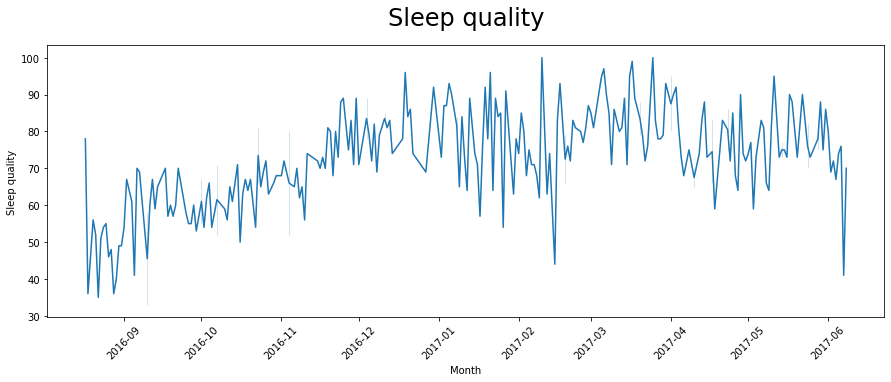

In [7]:
plt.figure(figsize=(15,5))

sns.lineplot(y = data_cleaned["Sleep quality"], x = data_cleaned["Start"])

plt.title("Sleep quality", pad=20, fontsize=24)
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.savefig('Sleep_quality_trendline.png')
print("Max sleep quality:", max(data_cleaned["Sleep quality"]), "Min sleep quality:", min(data_cleaned["Sleep quality"]))
plt.show()

Box plots were used to visualize the extracted feature "Weekend" with sleep quality. To extend the analysis, also all weekdays and sleep quality were plotted separately. From the plots, it can be observed that the sleep quality is relatively the same during all weekdays except on Fridays. On Fridays, the mean sleep quality is distinctly higher. 

Although, the rest of the days are similar, there are some differencies. For example on Mondays and Thursdays there is a lot of variation in sleep quality as the whiskers are long. Tuesday's whiskers are short which indicates that sleep quality stays relatively same.

In the boxplot with "Weekday" and "Weekend" the mean sleep quality is higher on weekend's boxplot and also the upper and lower whiskers communicate better sleep quality on weekends. It is worth noting that in this case Friday-Saturday, Saturday-Sunday and Sunday-Monday nights are considered as weekend nights.

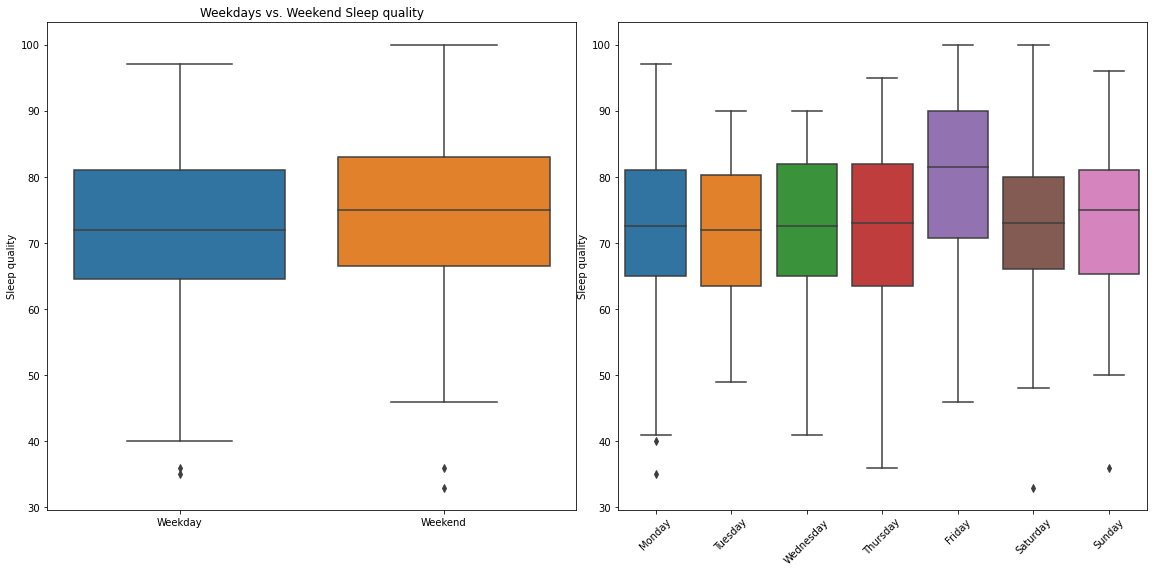

In [9]:
# Initialize a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekend'], y=data_cleaned['Sleep quality'], ax=ax1)
ax1.set_title("Weekdays vs. Weekend Sleep quality")
ax1.set_xticklabels(["Weekday", "Weekend"])
ax1.set(xlabel=None)

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Make a boxplot with seaborn
sns.boxplot(x=data_cleaned['Weekday'], y=data_cleaned['Sleep quality'], ax=ax2, order = order)
ax2.set_xlabel("Weekday")
ax2.set(xlabel=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
plt.savefig('Sleep_quality_weekday.png')
plt.show()

In [10]:
data_cleaned = data_cleaned.drop(["Start", "Weekday"], axis = 1)

Also, the extracted feature "Late to bed" was visualized with boxplots. Surprisingly, the mean sleep quality is higher when the subject went late to bed (between 00:00 and 05:59). Also, somewhat surprisingly there is less variation in sleep quality when the subject went to sleep late and there are no outliers. However, this is most probably explained by the low number of observations where the subject went late to sleep. 

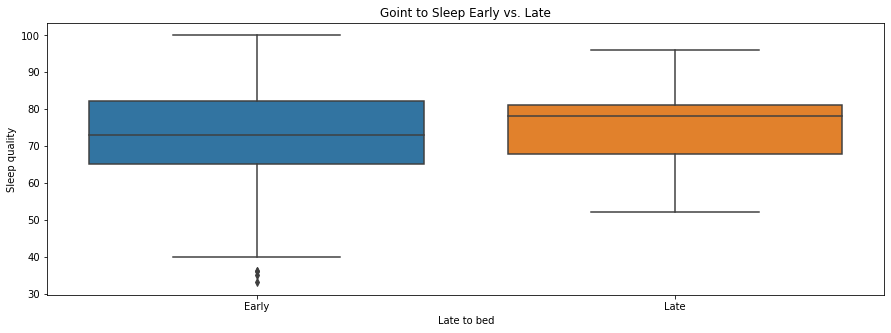

In [11]:
# Initialize a figure
plt.figure(figsize=(15,5))

# Make a boxplot with seaborn
ax = sns.boxplot(x=data_cleaned['Late to bed'], y=data_cleaned['Sleep quality'])
plt.title("Goint to Sleep Early vs. Late")
ax.set_xticklabels(["Early", "Late"])
plt.savefig('Sleep_quality_late.png')
plt.show()

In visual data analysis, the final step was plotting all featuers with a pairplot. For variables with continuous values, linear or logistic dependencies can be examined. In this case, based on the plots, there seems not to be linear dependencies as the data points are ball shaped.

We can also examine the distribution. Some interesting findings are that there are really few observations where the subject reported stress, late eating or went late to sleep.

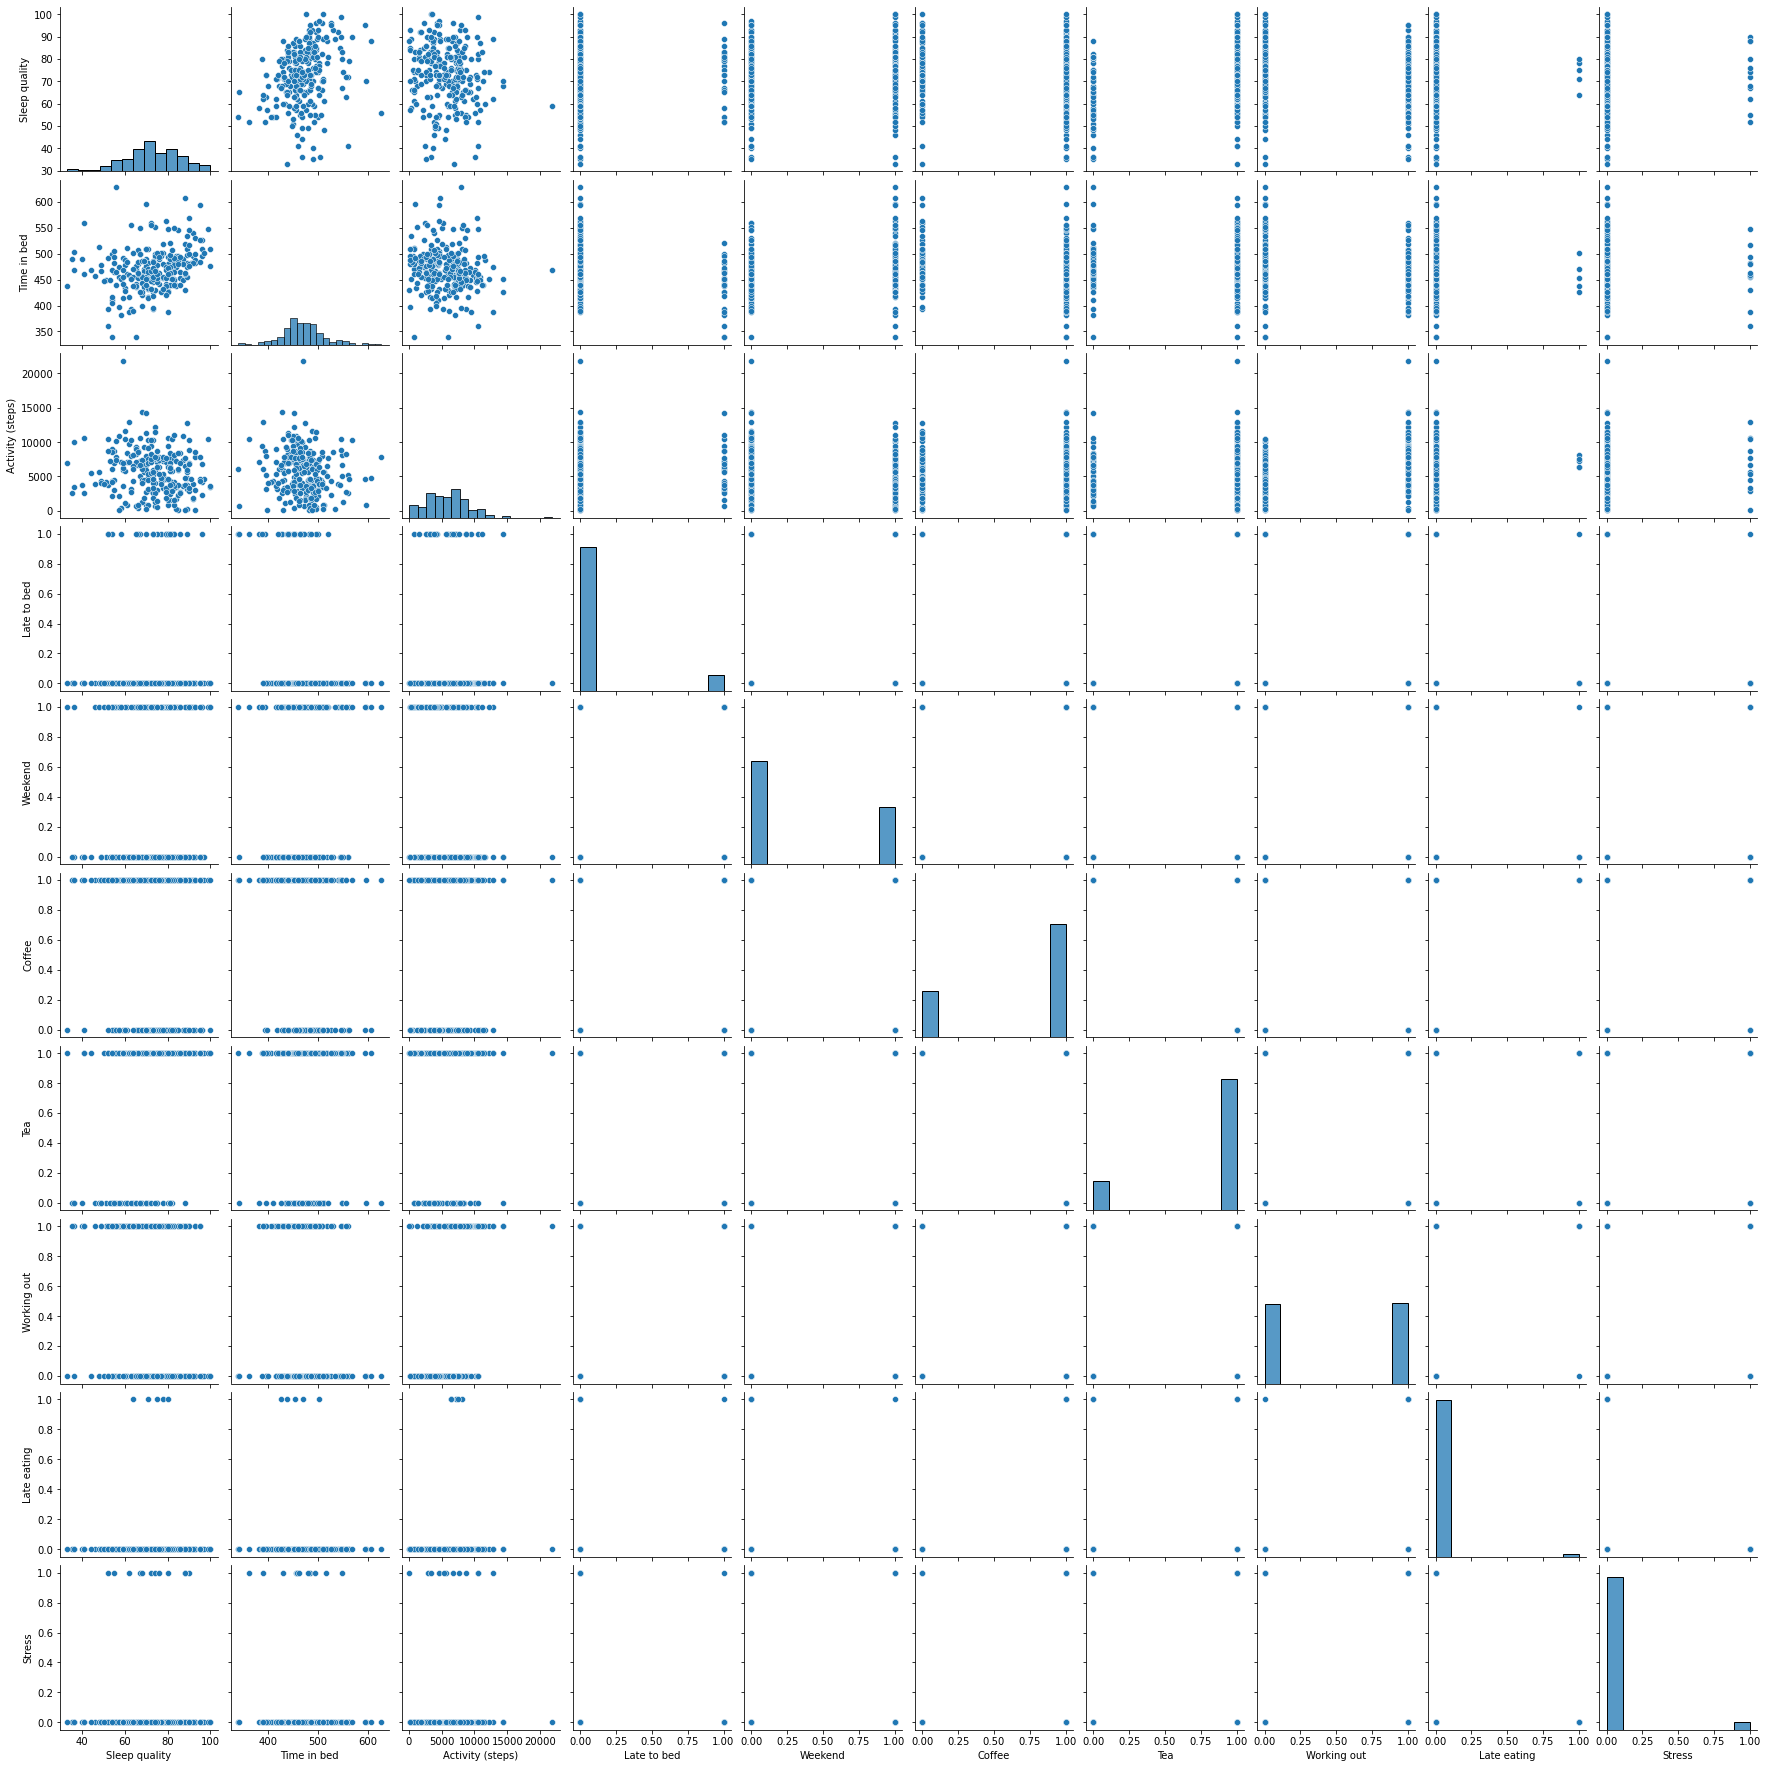

In [12]:
sns.pairplot(data_cleaned)
plt.savefig('Pairplot.png')
plt.show()

## 5.2 Feature Selection

In the feature selection the goal was to find a subset of variables that would be the most accurate in predicting sleep quality. The visual data analysis gave already some hints about the dependencies between sleep quality and other variables. Based on it, the feature selection continued with two phases:

1. Examining correlation
2. Using a wrapper method for feature selection

In the first phase, the covariance matrix indicated that sleep quality has the strongest association with tea (0.34) and time in bed (0.27) and the highest negative dependency with working out (-0.21). Based on the correlations, these three variables would be the best predictors for sleep quality. However, when combined together, other variables might perform better.
Some features had low dependencies such as stress (-0.0), late eating (0.01) and late to bed (0.04). However, this was expected because they were rare events meaning that most observations had the same binary value of zero.

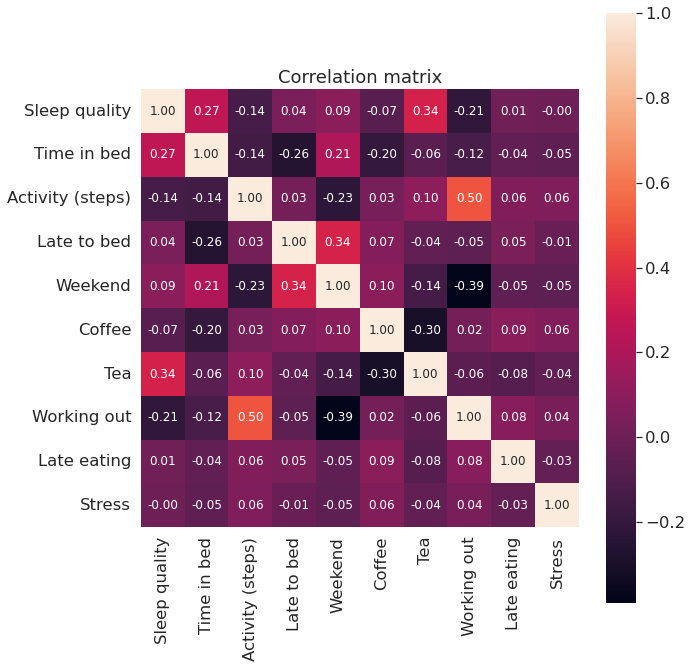

In [13]:
# Covariance matrix
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(data_cleaned.corr(),
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Correlation matrix')
plt.tight_layout() 
plt.savefig('Correlation_matrix.png')
plt.show() 

## 5.2.2 Wrapper Method for Feature Selection

In the second phase, a wrapper method was used for feature selection. In this case, bakward selection is used, which means that at first all features are included, and the least performing features are pruned out, until the predictive performance of the subset does not improve.

First the wrapper was used with linear regression. The proposed features for prediction by the wrapper were "Time in bed", "Tea", "Working out" and "Late to bed". After that the wrapper was used with support vector regression with the default radial basis function kernel. Then the proposed features were "Tea", "Working out", "Late eating" and "Stress". The shared features were "Tea" and "Working out" which also had higher absolute values for correlation with the dependent variable. The SVR did not include "Time in bed" which was little bit unexpected as it also had a higher correlation with the dependent variable.

Because there were differencies with the selected features, three training sets were constructed for the machine learning models. The first contains all features, the second contains the first wrapper's features and the third contains the second wrapper's features. The independent variables of the training sets can be seen in table 2.


| Training set 1   | Training set 2  | Training set 3 |
| -------------    | ----------- | ----------- |
| Time in bed      | Time in bed | -           |
| Activity (steps) | -           | -           |
| Coffee           | -           | -           |
| Tea              | Tea         | Tea         |
| Working out      | Working out | Working out |
| Late eating      | -           | Late eating |
| Stress           | -           | Stress      |
| Weekend          | -           | -           |
| Late to bed      | Late to bed | -           |
                                        
                                      Table 2

In [14]:
y = data_cleaned.iloc[:, 0]
X = data_cleaned.iloc[:, 1:]

# Scaling
scaler = StandardScaler()
X_names = list(X.columns.values)
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = X_names

X_train, X_test = data_cleaned.iloc[:230, 1:], data_cleaned.iloc[230:, 1:]
y_train, y_test = data_cleaned.iloc[:230, 0], data_cleaned.iloc[230:, 0]

# Regressors
lin_reg = LinearRegression()
svr = SVR()

# Sequential feature selection
lin_reg_sfs = SequentialFeatureSelector(lin_reg)
svr_sfs = SequentialFeatureSelector(svr)

lin_reg_sfs.fit(X_train, y_train)
svr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), direction = "backward")
SequentialFeatureSelector(estimator=SVR(), direction = "backward")

print("The proposed variables with the linear regression are:", lin_reg_sfs.get_feature_names_out())
print("The proposed variables with the support vector regressor are:", svr_sfs.get_feature_names_out())

The proposed variables with the linear regression are: ['Time in bed' 'Late to bed' 'Tea' 'Working out']
The proposed variables with the support vector regressor are: ['Tea' 'Working out' 'Late eating' 'Stress']


## 5.3 Predicting sleep quality with machine learning

Three models were used to predict sleep quality: linear regression, support vector regression with radial basis function kernel and support vector regression with polynomial kernel. Each model was trained separately with the three training sets. Training sets contained 230 observations (~90.6%) and the test set 24 observations. 

After training, the model were evaluated on the test set using mean squared error and $R^2$ score as the indicators of predictive performance. Evaluating based on MSE, the SVR with polynomial kernel achieved the best MSE of 101.7 out of the three models with the first and second training sets. SVR with radial basis function kernel came the second and linear regression the third. The order was different when evaluating with $R^2$ score as the linear model had the best score of -1.8 with the first training set. Also in this case, the SVR model with polynomial kernel performed better than the other SVR model.

In [15]:
X_train2, X_test2 = X_train[['Time in bed', 'Late to bed', 'Tea', 'Working out']], X_test[['Time in bed', 'Late to bed', 'Tea', 'Working out']]
X_train3, X_test3 = X_train[['Tea', 'Working out', 'Late eating', 'Stress']], X_test[['Tea', 'Working out', 'Late eating', 'Stress']]

training_sets = [(X_train, X_test), (X_train2, X_test2), (X_train3, X_test3)]

# Score tables
scores = [np.zeros((2, 3)) for i in range(3)]

# Linear regression
i = 0
for set in training_sets:
    lin_reg = LinearRegression()
    lin_reg.fit(set[0], y_train)
    y_pred = lin_reg.predict(set[1])
    scores[i][0,0] = int(mean_squared_error(y_pred, list(y_test)))
    scores[i][1,0] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
# SVR with 'rbf' kernel
i = 0
for set in training_sets:
    svr_reg = SVR(kernel = "rbf")
    svr_reg.fit(set[0], y_train)
    y_pred = svr_reg.predict(set[1])
    scores[i][0,1] = round(mean_squared_error(y_pred, list(y_test)),1)
    scores[i][1,1] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
# SVR with 'poly' kernel
i = 0
for set in training_sets:
    svr_reg = SVR(kernel = "poly")
    svr_reg.fit(set[0], y_train)
    y_pred = svr_reg.predict(set[1])
    scores[i][0,2] = round(mean_squared_error(y_pred, list(y_test)), 1)
    scores[i][1,2] = round(r2_score(y_pred, list(y_test)), 2)
    i += 1
    
for table in scores:    
    table = pd.DataFrame(table)
    table.columns = ["Linear", "SVR rbf", "SVR poly"]
    table.index = ["MSE", "R2 score"]
    display(table)

,Linear,SVR rbf,SVR poly
MSE,197.0,102.20,101.70
R2 score,-1.8,-36.34,-116.05


,Linear,SVR rbf,SVR poly
MSE,199.00,102.50,101.70
R2 score,-2.04,-227.76,-15.12


,Linear,SVR rbf,SVR poly
MSE,218.00,167.90,199.20
R2 score,-3.14,-4.95,-3.74


## 5.2 Results analysis

For Linear Regression, the best scores were MSE: 197 with Feature set 1 and $R^2$ score: with Feature set 1. For SVR with rbf kernel, the best scores were MSE: 102 with Feature set 1 and $R^2$ score: -5 with Feature set 3. For SVR with polynomial kernel, the best scores were MSE: 102 with Feature set 1 and $R^2$ score: -4 with Feature set 3.

Based on MSE we should select the model achieving lowest MSE. In this case we should select SVR rbf with Feature set 1. Based on $R^2$ score we should select the model achieving $R2$ score closest to 1. We should select Linear model with Feature set 2.

# 6. Conclusions & Discussion

In this project, the goal was to find patterns in sleep quality and use behaviour and time related features to predict sleep quality. When studying correlations, it turned out that coffee had only small negative dependency with sleep quality whereas tea had stronger association with sleep quality. Somewhat surprisingly, going late to bed, eating late and stress had little effect on sleep quality. Another surpsiring finding was that mean sleep quality was higher when the subject went late to bed. However, the subject went rarely late to sleep and there were less observations from such days which could have affected the results.

The subject's sleep quality was relatively similar during the other days except Fridays. On Fridays, the subject had considerably higher sleep quality which could indicate that on Friday-Saturday night the subject prioritises sleep or has some other positive behaviour that is not available in this dataset. When analysing subjects sleep quality visually over a longer time, the sleep quality varied day by day and no patterns were detected.

Three machine learning models - linear regression, support vector regression with radial basis function kernel and support vector regression with polynomial kernel were used to predict sleep quality. Three feature sets were constructed using the wrapper method with linear regression and support vector regression. These feature sets consisted one with all features and two subsets. Linear regression achieved the lowest mean squared error and $R^2$ score. However, all models performed poorly, which was somewhat expected as based on visual analysis of the plots, there were no clear dependencies between the sleep quality and the other variables.

In addition to weak predictions, the other challenges were that quite many observations needed to be discarded in the pre-processing due to missing values. For the same reason, heart rate was pruned out which would have been interesting to include in the analysis. Moreover, having data from more than one subject would have made the results more general, as this subject could have individual tendencies and anomalies. Finally, as the behaviour of the subject had little effect on sleep, which is contradictory to personal experiences, common sense and the literature, it begs the question how accurate the Sleep Cycle application's sleep quality scores are.

For future research, this dataset could be used to analyse how sleep affects behaviour during the following day such as caffeine consumption or stress or how sleep affects mood. However, this dataset is sort of limiting, as there seems not to be that high dependency between the given variables. If different data was collected such as the number of coffee and tea cups drank and when they were drank or how intensive workouts were and how late they were performed, there could be stronger dependencies to be found.

# 7. References

Atkinson, G., & Davenne, D. (2007). Relationships between sleep, physical activity and human health. Physiology and Behavior, 90(2–3), 229–235. https://doi.org/10.1016/j.physbeh.2006.09.015

Drake, C., Roehrs, T., Shambroom, J., & Roth, T. (2013). Caffeine effects on sleep taken 0, 3, or 6 hours before going to bed. Journal of Clinical Sleep Medicine, 9(11), 1195–1200. https://doi.org/10.5664/jcsm.3170

Thomsen, D. K., Mehlsen, M. Y., Christensen, S., & Zachariae, R. (2003). Rumination-relationship with negative mood and sleep quality.